# Otimização Linear 2 (SME5902)
## Pontos Interiores (ou Barreira para os íntimos)

### Docente: Professora Doutora Maristela Oliveira dos Santos
### Grupo:
- Abraão da Silva Guimarães (NUSP: 15404165)
- Thiago Rafael Mariotti Claudio (NUSP: 15611674)

### Motivação:
Implementação do método da barreira para o trabalho avaliativo final da disciplina de Otimização Linear 2, do programa de Pós Graduação pelo ICMC-USP.

---
# Sobre a implementação

In [30]:
"""
Célula de importação de módulos PATH
"""
import numpy as np
import matplotlib.pyplot as plt

In [23]:
def grad_f(x: np.array, c: np.array) -> np.array:
    """
    @About
    Realiza o calculo do gradiente da funcao objetivo.

    @param
    x: np.array, req
        Vetor contendo o valor atual das variaveis de decisao no espaco.
    c: np.array, req
        Vetor de coeficientes da funcao objetivo.

    @return
    c + np.sum(1 / x) [gradiente]: np.array
        Gradiente da funcao objetivo em termos de barreira.
    """
    return c + np.sum(1 / x)

In [24]:
def hessian_f(x):
    """
    @about
    Realiza o calculo da matriz Hessiana.

    @param
    x: np.array, req
        Vetor contendo o valor atual das variaveis de decisao no espaco.

    @return
    np.diag(1 / (x ** 2)) [Matriz Hessiana]: np.array
        Matriz Hessiana.
    """
    return np.diag(1 / (x ** 2))

In [25]:
def KKT(A, b, c, x, y, s):
    """
    @about
    Constroi o sistema KKT para verificacao das condicoes do sistema.

    @param
    A: np.array, req
        Matriz de coeficiente das restricoes do problema.
    b: np.array, req
        Vetor de recursos do problema (lado direito).
    x: np.array, req
        Vetor contendo o valor atual das variaveis de decisao no espaco.
    c: np.array, req
        Vetor de coeficientes da funcao objetivo.
    y: np.array, req
        Vetor de multiplicadores de Lagrange.
    s: np.array, req
        Vetor de variaveis de folga do problema.

    @return
    [sistema KKT]: np.array
        Sistema de condicoes KKT concatenado.
    """
    return np.concatenate([A.T @ y + s - c,
                           A @ x - b,
                           x * s])

In [26]:
def passo_newton(A, b, c, x, y, s):
    """
    @about
    Calcula o passo de Newton para solucao do sistema KKT.

    @param
    A: np.array, req
        Matriz de coeficiente das restricoes do problema.
    b: np.array, req
        Vetor de recursos do problema (lado direito).
    c: np.array, req
        The coefficients of the linear objective function.
    x: np.array, req
        The current point in the space of decision variables.
    y: np.array, req
        Vetor de multiplicadores de Lagrange.
    s: np.array, req
        Vetor de variaveis de folga do problema.

    @return
    delta_x: np.array
        Passo de Newton aplicado as variaveis de decisao.
    delta_y: np.array
        Passo de Newton aplicado as variaveis de Lagrange.
    delta_s: np.array
        Passo de Newton aplicado as variaveis de folga.
    """
    m, n = A.shape
    X_inv = np.diag(1 / x)
    S_inv = np.diag(1 / s)
    
    KKT_matrix = np.block([
        [np.zeros((n, n)), A.T, np.eye(n)],
        [A, np.zeros((m, m)), np.zeros((m, n))],
        [np.diag(s), np.zeros((n, m)), np.diag(x)]
    ])
    
    KKT_rhs = -KKT(A, b, c, x, y, s)
    
    delta = np.linalg.solve(KKT_matrix, KKT_rhs)
    return delta[:n], delta[n:n + m], delta[n + m:]

In [41]:
def metodo_barreira_main(A, b, c, x0=None, tol=1e-8, mu=10, max_iter=100):
    """
    @about
    Codigo drive do solver.
    Implementa o metodo da barreira, realizando a chamada das funcoes operacionais.

    @param
    A: np.array, req
        Matriz de coeficiente das restricoes do problema.
    b: np.array, req
        Vetor de recursos do problema (lado direito).
    c: np.array, req
        The coefficients of the linear objective function.
    x0: np.array, optional
        The initial guess for the decision variables. Default is None, which sets it to a vector of ones.
    tol: float, optional
        The tolerance for convergence. Default is 1e-8.
    mu: float, optional
        The barrier parameter. Default is 10.
    max_iter: int, optional
        The maximum number of iterations. Default is 100.

    @return
    x: np.array
        Vetor contendo o valor final das variaveis de decisao do sistema
    y: np.array
        Vetor contendo o valor final das variaveis de Lagrange do sistema
    s: np.array
        Vetor contendo o valor final das variaveis de folga do sistema
    log: list of tuples
        Lista de tuplas contendo o historico de (x, y, s) em cada iteracao.
    """
    m, n = A.shape
    if x0 is None:
        x0 = np.ones(n)
    
    x = x0
    y = np.zeros(m)
    s = np.ones(n)
    log = []

    for _ in range(max_iter):
        log.append((x.copy(), y.copy(), s.copy())) 
        res = KKT(A, b, c, x, y, s)
        if np.linalg.norm(res) < tol:
            break
        
        delta_x, delta_y, delta_s = passo_newton(A, b, c, x, y, s)
        
        alpha = 1
        while np.any(x + alpha * delta_x <= 0) or np.any(s + alpha * delta_s <= 0):
            alpha *= 0.5
        
        x += alpha * delta_x
        y += alpha * delta_y
        s += alpha * delta_s
    
    return x, y, s, log

In [49]:

def plot_evolucao_sol(A, b, evolucao_log):
    """
    @about
    Plota a evolucao do sistema (somente bidimensional).

    @param
    A: np.array, req
        Matriz de coeficiente das restricoes do problema.
    b: np.array, req
        Vetor de recursos do problema (lado direito).
    evolucao_log: list of tuples, req
        Lista de tuplas contendo o historico de (x, y, s) em cada iteracao.

    @return
    None

    @raises
    Exception: se o sistema nao e bidimensional, nao e realizado plot.
    """

    if len(evolucao_log[0][0]) - len(b) != 2:
        raise Exception("O sistema nao e bidimensional (2 variaveis de decisao), portanto nao sera realizada plotagem.")

    x1_vals = np.linspace(-5, 10, 400)
    x2_vals = np.linspace(-5, 10, 400)
    x1, x2 = np.meshgrid(x1_vals, x2_vals)
    
    constraints = []
    for i in range(A.shape[0]):
        constraint = b[i] - A[i, 0] * x1 - A[i, 1] * x2
        constraints.append(constraint)

    plt.figure(figsize=(10, 6))
    for constraint in constraints:
        plt.contour(x1, x2, constraint, levels=[0], colors=['blue'])

    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    
    evolucao_log_x1 = [h[0][0] for h in evolucao_log]
    evolucao_log_x2 = [h[0][1] for h in evolucao_log]
    plt.plot(evolucao_log_x1, evolucao_log_x2, marker='o', color='red')
    
    plt.title('Regiao Factivel e Evolucao da Solucao')
    plt.xlim([-5, 10])
    plt.ylim([-5, 10])
    plt.show()

# Exemplos

## 1 - Arenales (exemplo 3.16)

$$\text{Minimizar} f(x) = -x_1 - 2x_2 + 0x_3 + 0x_4 + 0x_5$$
$$\text{Sujeito a:}$$
$$x_1 + x_2 + x_3 = 6$$
$$x_1 - x_2 + x_4 = 4$$
$$-x_1 + x_2 + x_5 = 4$$
$$x_i \geq 0 \quad \forall i = {1,2,3,4,5}$$

Valores de X:  [1.00000000e+00 5.00000000e+00 4.52274203e-10 7.99999999e+00
 3.45703083e-11]
Valores de Y:  [-1.50000000e+00  1.37229788e-09 -4.99999997e-01]
Valores de S:  [1.13840975e-09 2.70062133e-11 1.50000000e+00 2.85810969e-12
 4.99999999e-01]


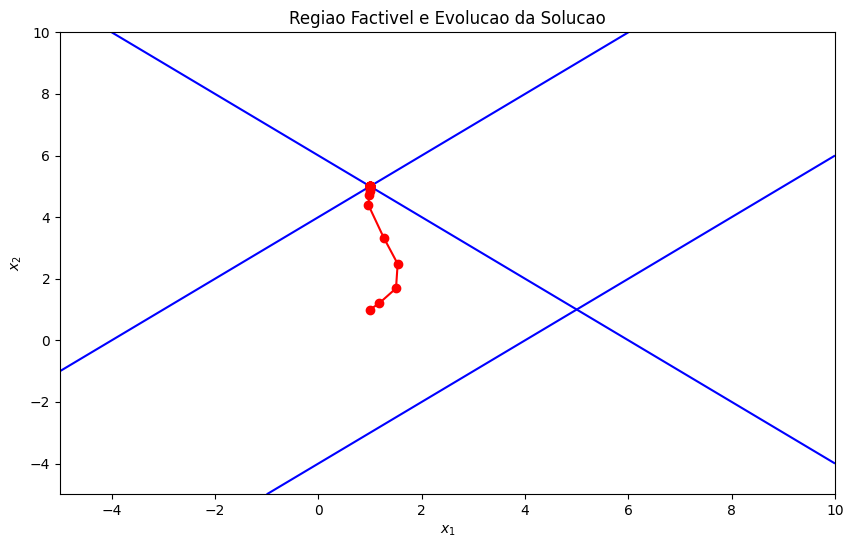

In [55]:
A = np.array([
    [1, 1, 1, 0, 0],
    [1, -1, 0, 1, 0],
    [-1, 1, 0, 0, 1]
])
b = np.array([6, 4, 4])
c = np.array([-1, -2, 0, 0, 0])

# Executando o algoritmo de pontos interiores
x, y, s, log = metodo_barreira_main(A, b, c)
print("Valores de X: ", x)
print("Valores de Y: ", y)
print("Valores de S: ", s)
plot_evolucao_sol(A, b, log)

## 2 - Slides (nº 72)

$$\text{Minimizar} f(x) = - x_1 - x_2$$
 
$$x_1 + x_2 \leq 6$$
$$x_1 - x_2 \leq 4$$
$$- x_1 + x_2 \leq 4$$
$$x_i \geq 0 \quad \forall i = {1,2} $$

Valores de X:  [2.99999982e+00 3.00000018e+00 6.21779240e-10 4.00000036e+00
 3.99999963e+00]
Valores de Y:  [-9.99999998e-01  1.21839218e-09  1.21839217e-09]
Valores de S:  [3.42952525e-12 3.42952442e-12 9.99999999e-01 3.96870344e-12
 3.96870488e-12]


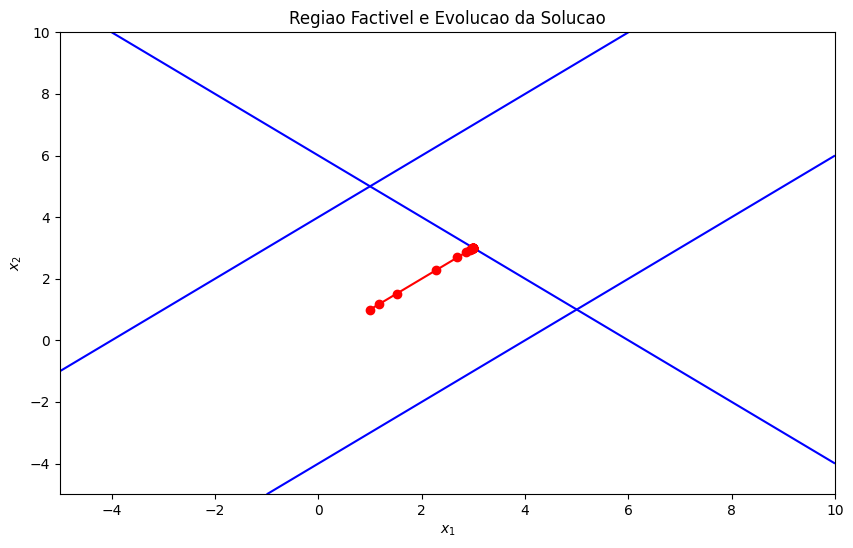

In [56]:
A = np.array([
    [1, 1, 1, 0, 0],
    [1, -1, 0, 1, 0],
    [-1, 1, 0, 0, 1]
])
b = np.array([6, 4, 4])
c = np.array([-1, -1, 0, 0, 0])

# Executando o algoritmo de pontos interiores
# Executando o algoritmo de pontos interiores
x, y, s, log = metodo_barreira_main(A, b, c)
print("Valores de X: ", x)
print("Valores de Y: ", y)
print("Valores de S: ", s)
plot_evolucao_sol(A, b, log)

## 3 - Slides (nº 80) - Exemplo ilimitado

$$\text{Minimizar} f(x) = - x_1 - x_2$$
 
$$x1 - x2 \leq 4$$
$$- x1 + x2 \leq 4$$
$$x_i \geq 0 \quad \forall i = {1,2} $$

Valores de X:  [2.04310303e+21 2.04310303e+21 2.50000000e+00 2.50000000e+00]
Valores de Y:  [0.42039728 0.42039728]
Valores de S:  [2.85473378e-55 2.85473378e-55 7.96027219e-02 7.96027219e-02]


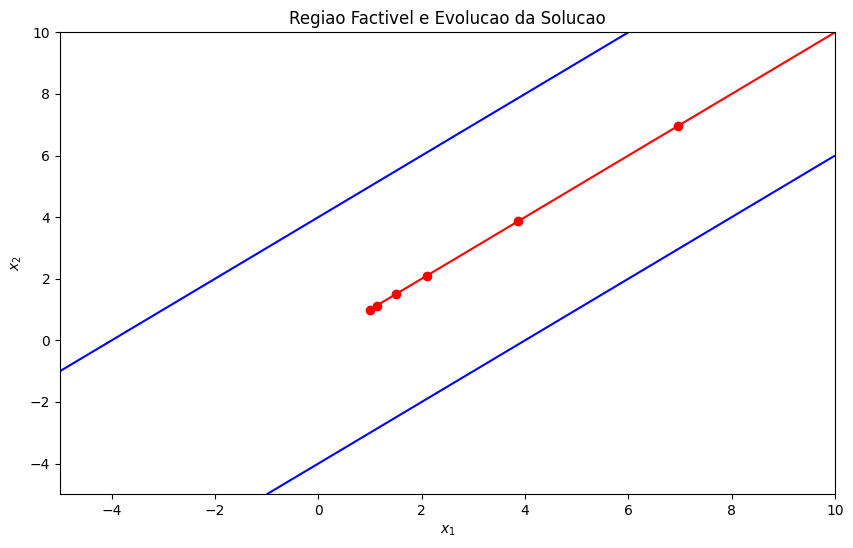

In [57]:
A = np.array([
    [1, -1, 1, 0],
    [-1, 1, 0, 1]
])
b = np.array([4, 4])
c = np.array([-1, -1, 0, 0])

# Executando o algoritmo de pontos interiores
x, y, s, log = metodo_barreira_main(A, b, c)
print("Valores de X: ", x)
print("Valores de Y: ", y)
print("Valores de S: ", s)
plot_evolucao_sol(A, b, log)

## 4 - [Munari](https://www.youtube.com/watch?v=welOPSBIWjk&list=PLjK8TkmwOe0qQiJwSB_uxGsUNf54HPeS8&index=22)

$$\text{Maximizar} f(x) = x_1 + x_2 + 0x_3 + 0x_4 + 0x_5$$
$$\text{Sujeito a:}$$
$$0,5x_1 + 0,3x_2 + x_3 = 3$$
$$0,1x_1 + 0,2x_2 + x_4 = 1$$
$$0,4x_1 + 0,5x_2 + x_5 = 3$$
$$x_i \geq 0 \quad \forall i = {1,2,3,4,5}$$

Valores de X:  [4.61538460e+00 2.30769231e+00 1.95511309e-09 7.69230782e-02
 5.00456567e-10]
Valores de Y:  [-7.69230775e-01 -4.82007395e-08 -1.53846151e+00]
Valores de S:  [6.39968838e-11 5.10262843e-10 7.69230778e-01 5.05581498e-08
 1.53846151e+00]


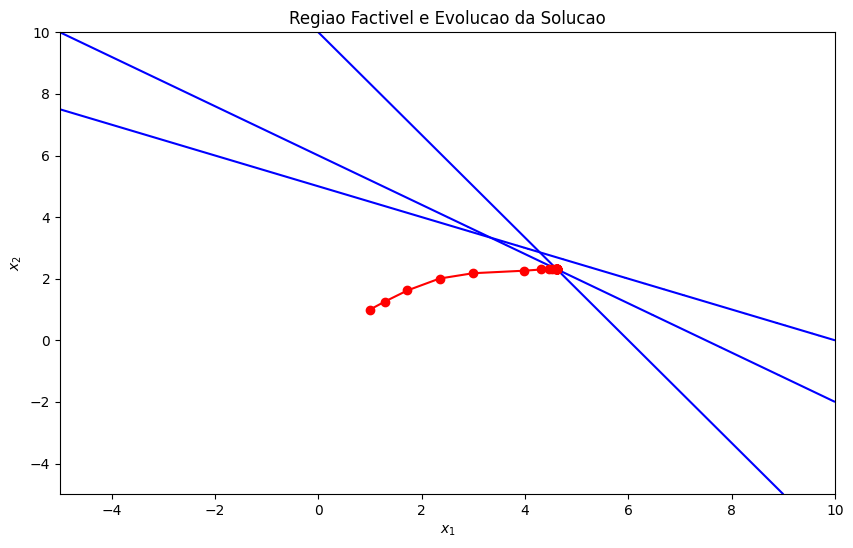

In [58]:
A = np.array([
    [0.5, 0.3, 1, 0, 0],
    [0.1, 0.2, 0, 1, 0],
    [0.4, 0.5, 0, 0, 1],
])
b = np.array([3, 1, 3])
c = np.array([-1, -1, 0, 0, 0])

# Executando o algoritmo de pontos interiores
x, y, s, log = metodo_barreira_main(A, b, c)
print("Valores de X: ", x)
print("Valores de Y: ", y)
print("Valores de S: ", s)
plot_evolucao_sol(A, b, log)